In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score

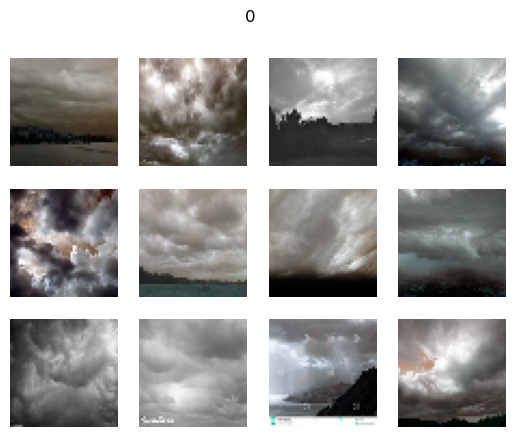

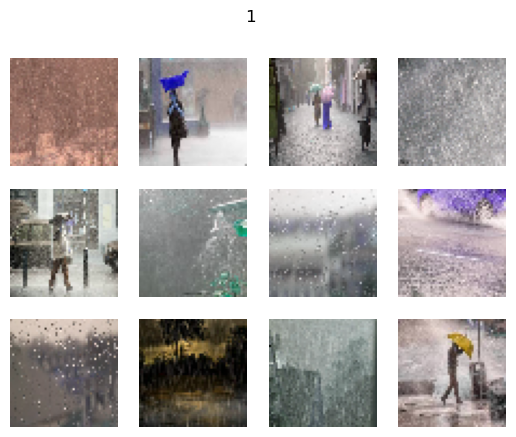

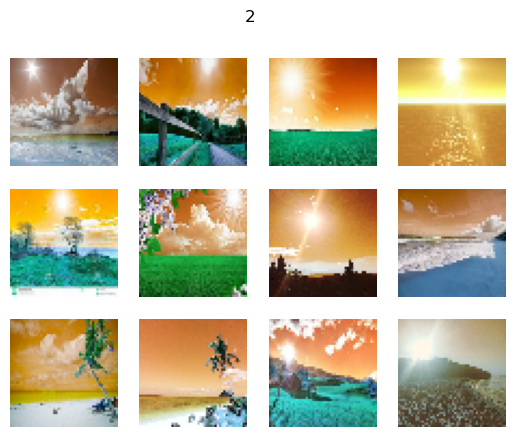

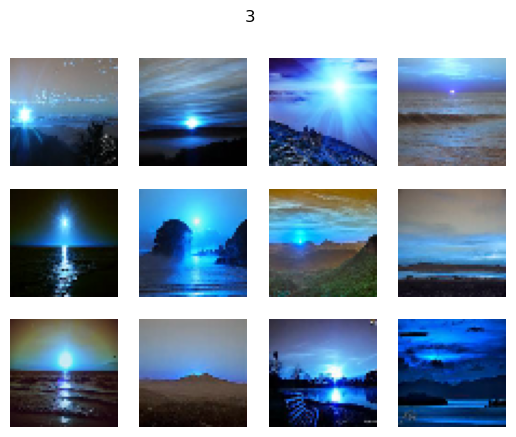

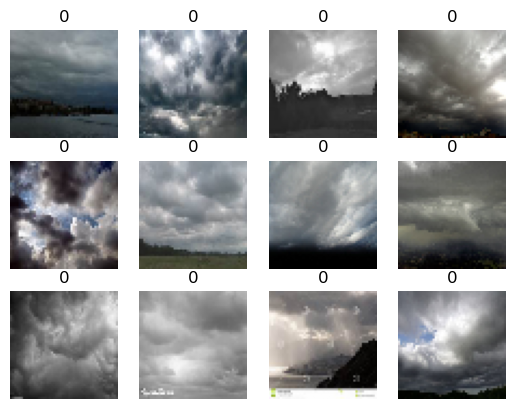

In [12]:
# Укажите свой путь до изображений
path = '/Users/yaroslav/Documents/Python/SessionPython/final_proj/Weather Resized/'

# Список меток (классов) — предположительно:
# '0' = cloudy, '1' = rain, '2' = shine, '3' = sunrise (или другой порядок — зависит от датасета)
categories = ['0', '1', '2', '3']

# Визуализация нескольких изображений из каждой категории
# Для каждой категории создаём отдельное окно с сеткой 3x4 (12 изображений)
for category in categories:
    fig, _ = plt.subplots(3, 4)
    fig.suptitle(category)
    for k, v in enumerate(os.listdir(path + category)[:12]):
        img = plt.imread(path + category + '/' + v)
        plt.subplot(3, 4, k + 1)
        plt.axis('off')
        plt.imshow(img)
    plt.show()

# Параметры для предобработки изображений:
# HEIGHT, WIDTH — целевой размер изображений после изменения
# N_CHANNELS = 3 — цветные изображения (RGB)
HEIGHT, WIDTH, N_CHANNELS = 50, 50, 3
# Списки для хранения самих изображений (data) и их меток (labels)
data = []
labels = []

for k, category in enumerate(categories):
    for f in os.listdir(path + category):
        image = cv2.imread(path + category + '/' + f)
        image = cv2.resize(image, (WIDTH, HEIGHT))
        data.append(image)
        labels.append(k)

# Преобразуем списки в NumPy-массивы для удобства работы с ML-библиотеками
data = np.array(data, dtype="float32") / 255.0  # Нормализация пикселей в диапазон [0, 1]
labels = np.array(labels)  # Метки — целые числа от 0 до 3

# Визуализация первых 12 предобработанных изображений из всего датасета
plt.subplots(3, 4)  # Создаём новую фигуру с 12 подграфиками
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(data[i])
    plt.axis('off')
    plt.title(categories[labels[i]])
plt.show()

# Разделяем данные на обучающую и тестовую выборки
# test_size=0.2 — 20% данных пойдёт в тест, 80% — в обучение
# random_state=42 — для воспроизводимости результатов
trainX, testX, trainY, testY = train_test_split(
    data, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels  # (опционально, но рекомендуется) — сохраняет пропорции классов в обеих выборках
)

## Custom Dataset Class

In [4]:
# Определяем собственный класс датасета, наследуемый от torch.utils.data.Dataset
# Это стандартный способ интеграции собственных данных в PyTorch
class WeatherDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Инициализация датасета.
        - images: массив NumPy или список изображений (обычно в формате HWC — высота, ширина, каналы)
        - labels: массив меток (целые числа)
        - transform: опциональная цепочка преобразований (например, ToTensor, Normalize и т.д.)
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        """Возвращает общее количество образцов в датасете."""
        return len(self.images)

    def __getitem__(self, idx):
        """
        Возвращает один элемент датасета по индексу idx.
        - Загружает изображение и метку.
        - Применяет трансформации (если заданы).
        """
        image = self.images[idx]  # Получаем изображение (уже загружено в память)
        label = self.labels[idx]  # Получаем соответствующую метку

        # Применяем трансформации (например, преобразование в тензор)
        if self.transform:
            image = self.transform(image)

        return image, label


# Определяем цепочку трансформаций с помощью torchvision.transforms
transform = transforms.Compose([
    transforms.ToTensor()  # Преобразует массив NumPy (HWC, значения [0,1]) в тензор (CHW, torch.float32)
])

# Создаём экземпляры датасетов для обучающей и тестовой выборок
train_dataset = WeatherDataset(trainX, trainY, transform=transform)
test_dataset = WeatherDataset(testX, testY, transform=transform)

# Создаём DataLoader'ы — они будут формировать батчи, перемешивать и загружать данные параллельно
train_loader = DataLoader(
    train_dataset,
    batch_size=32,    # Количество образцов в одном батче
    shuffle=True      # Перемешивать данные при каждой эпохе (только для обучения!)
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False     # Не перемешивать при тестировании — порядок не важен, но воспроизводимость лучше
)


## Model Definition

In [5]:
class WeatherCNN(nn.Module):
    def __init__(self):
        super(WeatherCNN, self).__init__()

        # Первый свёрточный слой:
        # вход: 3 канала (RGB), выход: 32 фильтра, ядро 2x2
        self.conv1 = nn.Conv2d(3, 32, kernel_size=2)

        # Первый max-pooling: уменьшает размер в 2 раза по высоте и ширине
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        # Второй свёрточный слой: 32 → 32 признака, ядро 2x2
        self.conv2 = nn.Conv2d(32, 32, kernel_size=2)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # Dropout для предотвращения переобучения (отключает 25% нейронов случайно)
        self.dropout1 = nn.Dropout(0.25)

        # Преобразует многомерный тензор в вектор (для подачи в полносвязный слой)
        self.flatten = nn.Flatten()

        # Первый полносвязный слой
        # Вход: 32 * 11 * 11 — нужно проверить, верно ли это!
        self.fc1 = nn.Linear(32 * 11 * 11, 128)

        self.dropout2 = nn.Dropout(0.5)

        # Выходной слой: 4 класса (погода)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.dropout1(x)
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x


model = WeatherCNN()
print(model)


WeatherCNN(
  (conv1): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3872, out_features=128, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)


## Model Training

In [6]:
#Берёт первый батч из train_loader, печатает форму тензора до и после перестановки осей.
for images, labels in train_loader:
    print(images.shape)  # Before permutation
    images = images.permute(0, 3, 1, 2)
    print(images.shape)  # After permutation
    break


torch.Size([32, 3, 50, 50])
torch.Size([32, 50, 3, 50])


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# ГИПЕРПАРАМЕТРЫ
learning_rate = 0.001
epochs = 25

# ФУНКЦИЯ ПОТЕРЬ И ОПТИМИЗАТОР
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# ЦИКЛ ОБУЧЕНИЯ
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Прямой проход
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Обратный проход
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")


Epoch 1/25, Loss: 1.0186
Epoch 2/25, Loss: 0.6570
Epoch 3/25, Loss: 0.5405
Epoch 4/25, Loss: 0.5076
Epoch 5/25, Loss: 0.4953
Epoch 6/25, Loss: 0.4225
Epoch 7/25, Loss: 0.3797
Epoch 8/25, Loss: 0.3656
Epoch 9/25, Loss: 0.3666
Epoch 10/25, Loss: 0.3282
Epoch 11/25, Loss: 0.2983
Epoch 12/25, Loss: 0.3076
Epoch 13/25, Loss: 0.2406
Epoch 14/25, Loss: 0.2864
Epoch 15/25, Loss: 0.3409
Epoch 16/25, Loss: 0.2632
Epoch 17/25, Loss: 0.2342
Epoch 18/25, Loss: 0.2665
Epoch 19/25, Loss: 0.2423
Epoch 20/25, Loss: 0.1936
Epoch 21/25, Loss: 0.1976
Epoch 22/25, Loss: 0.2188
Epoch 23/25, Loss: 0.1719
Epoch 24/25, Loss: 0.1434
Epoch 25/25, Loss: 0.1487


 ## Evaluation and Confusion Matrix

Исходная форма изображения: torch.Size([32, 3, 50, 50])
Форма изображения после пропуска перестановки: torch.Size([32, 3, 50, 50])
Исходная форма изображения: torch.Size([32, 3, 50, 50])
Форма изображения после пропуска перестановки: torch.Size([32, 3, 50, 50])
Исходная форма изображения: torch.Size([32, 3, 50, 50])
Форма изображения после пропуска перестановки: torch.Size([32, 3, 50, 50])
Исходная форма изображения: torch.Size([32, 3, 50, 50])
Форма изображения после пропуска перестановки: torch.Size([32, 3, 50, 50])
Исходная форма изображения: torch.Size([32, 3, 50, 50])
Форма изображения после пропуска перестановки: torch.Size([32, 3, 50, 50])
Исходная форма изображения: torch.Size([32, 3, 50, 50])
Форма изображения после пропуска перестановки: torch.Size([32, 3, 50, 50])
Исходная форма изображения: torch.Size([32, 3, 50, 50])
Форма изображения после пропуска перестановки: torch.Size([32, 3, 50, 50])
Исходная форма изображения: torch.Size([1, 3, 50, 50])
Форма изображения после проп

/var/folders/9c/p_z6c2m52pn71250yf4hc6500000gn/T/ipykernel_3392/1432762263.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + categories)
/var/folders/9c/p_z6c2m52pn71250yf4hc6500000gn/T/ipykernel_3392/1432762263.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + categories)


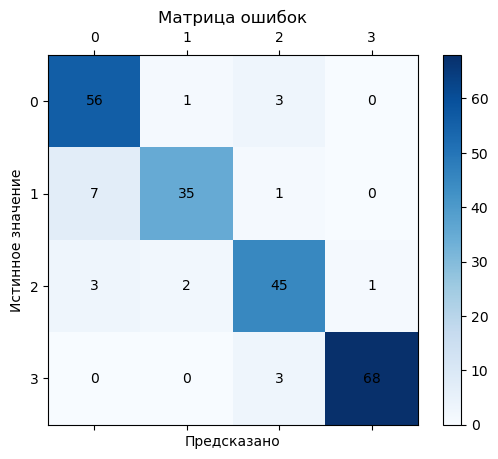

In [9]:
# Оценка модели
model.eval()  # Переводим модель в режим оценки (отключает dropout, batch norm и т.д.)
all_preds = []      # Список для хранения предсказанных меток
all_labels = []     # Список для хранения истинных меток

# Отключаем вычисление градиентов — ускоряет работу и снижает потребление памяти
with torch.no_grad():
    for images, labels in test_loader:  # Используем тестовый загрузчик данных
        # Проверяем форму изображений до перестановки
        print(f"Исходная форма изображения: {images.shape}")

        # Поскольку изображения уже имеют правильную форму, перестановка не требуется
        # images = images.permute(0, 3, 1, 2)  # Нет необходимости в перестановке

        # Проверяем форму после пропуска перестановки
        print(f"Форма изображения после пропуска перестановки: {images.shape}")

        # Прямой проход: получаем выход модели (логиты)
        outputs = model(images)

        # Получаем предсказания: индекс класса с максимальным логитом
        preds = torch.argmax(outputs, axis=1)

        # Сохраняем предсказания и истинные метки (переносим на CPU и конвертируем в NumPy)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Вычисляем точность (accuracy)
accuracy = accuracy_score(all_labels, all_preds)
print(f"Точность: {accuracy * 100:.2f}%")

# Матрица ошибок (confusion matrix)
cm = confusion_matrix(all_labels, all_preds)

# Визуализация матрицы ошибок
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap='Blues')
plt.title('Матрица ошибок')
fig.colorbar(cax)

# Устанавливаем подписи осей
ax.set_xticklabels([''] + categories)
ax.set_yticklabels([''] + categories)

# Добавляем числовые значения внутрь ячеек матрицы
for i in range(len(categories)):
    for j in range(len(categories)):
        ax.text(i, j, cm[j, i], va='center', ha='center')

plt.xlabel('Предсказано')
plt.ylabel('Истинное значение')
plt.show()